# **Exploração Visual das Correspondências de Cândido Portinari através de Metadados Textuais**
#### **por Micaele Brandão e Mateus Bandeira**

### **Tópicos**
1. Introdução
2. Configuração de ambiente
3. Coleta e limpeza de dados  
4. Características do DataFrame final 
5. Visualizações  
6. Conclusão e Referências


# 1. Introdução

Este projeto se trata de uma exploração visual das corresponências de Cândido Portinari, pintor brasileiro e um dos principais nomes do Modernismo. Um artista muito importante para a história do Brasil, como disse Israel Pedrosa: “Nenhum pintor pintou mais um País do que Portinari pintou o seu”. Nesse sentido, por meio do processamento de metadados textuais, buscamos identificar padrões temáticos nas comunicações do artista, mapear sua extensa rede de interlocutores e contextualizar cronologicamente os principais marcos de sua carreira. Para isso, utilizamos técnicas de web scraping, um método de coleta automatizada que permite extrair grandes volumes de dados de plataformas digitais, convertendo registros dispersos em uma base estruturada. O objetivo central é transformar esses documentos históricos em insights visuais que facilitem a compreensão da trajetória pessoal e profissional do artista. Ao transformar correspondências em representações gráficas, o projeto permite visualizar de forma intuitiva a circulação de Portinari no cenário artístico global, evidenciando como sua produção e seus diálogos ajudaram a moldar a identidade cultural do Brasil.

O repositório deste projeto está disponível no GitHub através do link: [Repositório portinari-metadata](https://github.com/vrsmic/portinari-metadata/tree/main)


# 2. Configuração de ambiente

In [2]:
import pandas as pd
import altair as alt
import numpy as np
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#scrapping 1
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time

#scrapping 2
import asyncio
import random

# apenas para fazer o scrapping, necessita de comandos no terminal.
#from playwright.async_api import async_playwright
#from tqdm.notebook import tqdm

import re
import warnings
# configuração opcional para suprimir avisos de concatenação futura, se desejar
warnings.simplefilter(action='ignore', category=FutureWarning)


# 3. Coleta e limpeza de dados

## 3.1. Coleta dos dados
Códigos para fazer o web scrapping do site com as correspondências de Portinari.

#### 3.1.1. Método 1
Funciona de maneira mais rápida e organiza melhor o dataframe, porém causa alguns erros.


In [ ]:
BASE_URL = "https://www.docvirt.com/docreader.net/DocReader.aspx"
BIB = "coportinari"
DOC_ID = "4645702686696"
TOTAL_PAGINAS = 9126  # ajuste conforme necessário
PARALLEL_PAGES = 2  

async def extract_page(context, pagina, max_retries=3):
    url = f"{BASE_URL}?bib={BIB}&id={DOC_ID}&pagfis={pagina}"
    
    for tentativa in range(max_retries):
        page = await context.new_page()
        try:
            # navegação em que o networkidle espera o AJAX terminar
            await page.goto(url, wait_until="networkidle", timeout=30000)

            # espera o elemento existir no DOM
            await page.wait_for_selector("#TextoDigitadoTxt", state="attached", timeout=15000)

            # espera ativa pelo JS do navegador até que o texto apareça
            # se em 10 segundos o length continuar 0, ele solta um TimeoutError
            try:
                await page.wait_for_function(
                    """() => {
                        const el = document.getElementById("TextoDigitadoTxt");
                        return el && el.value.length > 5;
                    }""",
                    timeout=10000 
                )
            except:
                # se der timeout aqui, pode ser que a página realmente não tenha texto, so a imagem, ou que o OCR falhou, ou que o carregamento demorou demais
                pass

            # extração
            dados = await page.evaluate("""() => {
                const textoEl = document.getElementById("TextoDigitadoTxt");
                const tituloEl = document.getElementById("PastaTxt");
                return {
                    conteudo: textoEl ? textoEl.value.trim() : "",
                    titulo: tituloEl ? tituloEl.innerText.trim() : ""
                }
            }""")
            
            conteudo = dados['conteudo']
            titulo = dados['titulo']

            # validação
            status = "sucesso"
            if not conteudo:
                # se passou pelo wait_for_function e ainda está vazio, assumimos que a página não tem OCR
                status = "vazio_ou_imagem"
            
            # Se for sucesso ou vazio confirmado, retornamos (não tentamos de novo)
            return {
                "pagina": pagina,
                "titulo": titulo,
                "conteudo": conteudo,
                "status": status
            }

        except Exception as e:
            # erros de conexão ou crash do navegador
            if tentativa == max_retries - 1:
                print(f"Erro final pág {pagina}: {str(e)[:100]}")
                return {
                    "pagina": pagina,
                    "titulo": None,
                    "conteudo": None,
                    "status": "erro_fatal"
                }
            
            # backoff exponencial
            await asyncio.sleep((tentativa + 1) * 3)
            
        finally:
            await page.close()

async def main():
    resultados = []

    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        
        context = await browser.new_context(
            user_agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
            viewport={"width": 1280, "height": 720}
        )
        
        sem = asyncio.Semaphore(PARALLEL_PAGES)

        async def worker(pagina):
            async with sem:
                # Ppequeno atraso aleatório antes de começar para não bater no servidor tudo junto
                await asyncio.sleep(random.uniform(0.1, 1.5))
                return await extract_page(context, pagina)

        # ajuste do range 
        tasks = [worker(i) for i in range(1, TOTAL_PAGINAS + 1)]

        for coro in tqdm(asyncio.as_completed(tasks), total=len(tasks), desc="Extraindo DocVirt"):
            r = await coro
            resultados.append(r)

        await browser.close()

    df = pd.DataFrame(resultados).sort_values("pagina")
    
    # salva CSV
    df.to_csv("dados_docvirt_fixed.csv", index=False, encoding="utf-8-sig")

    # relato
    sucessos = df[df['status'] == 'sucesso']
    vazios = df[df['status'] == 'vazio_ou_imagem']
    erros = df[df['status'] == 'erro_fatal']

    print("-" * 30)
    print(f"Total Processado: {len(df)}")
    print(f"Sucessos (com texto): {len(sucessos)}")
    print(f"Vazios (provável só imagem): {len(vazios)}")
    if not vazios.empty:
        print(f"   Páginas vazias: {vazios['pagina'].head(10).tolist()}...")
    print(f"Erros Fatais: {len(erros)}")
    
    # passar o df para um csv
    df.to_csv("dados_docvirt.csv", index=False)

# pra rodar no Jupyter/Colab:
# await main()

#### 3.1.2. Método 2
Garante a leitura dos metadados, pois sempre espera carregar a palavra de referência, mas não retorna de maneira organizada.

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, StaleElementReferenceException, NoSuchElementException
import time

# obs: o driver será criado/fechado no bloco que itera as páginas,
# para evitarmos criar/fechar o chrome a cada página (isso reduz falhas intermitentes)
# aqui deixamos apenas as importações e utilitários

def extract_text_from_page(url, driver, max_wait=10, check_interval=0.05):
    """
    Extrai 'titulo' e 'conteudo' com polling inteligente baseado em marcador.
    
    Estratégia:
    - Aguarda elemento aparecer
    - Polling frequente (50ms) verificando se conteúdo começa com 'COD_TIPO:'
    - Retorna IMEDIATAMENTE assim que marcador é detectado (sem wait desnecessário)
    - Max wait total de 10s como fallback
    """
    start_time = time.time()
    
    try:
        driver.get(url)
        
        # aguarda elemento aparecer no DOM
        wait = WebDriverWait(driver, max_wait)
        wait.until(EC.presence_of_element_located((By.ID, "TextoDigitadoTxt")))
        
        # = POLLING INTELIGENTE COM MARCADOR
        conteudo = None
        content_found = False
        
        while time.time() - start_time < max_wait:
            try:
                conteudo = driver.execute_script("""
                    var el = document.getElementById('TextoDigitadoTxt');
                    if (!el) return null;
                    var text = el.value || el.innerText || el.textContent || '';
                    return text.trim() || null;
                """)
                
                # verifica se tem o marcador 
                if conteudo and 'COD_TIPO:' in conteudo:
                    content_found = True
                    break
                elif conteudo:
                    # tem algo mas sem marcador - aguarda mais um pouco
                    time.sleep(check_interval)
                else:
                    # vazio ainda - aguarda
                    time.sleep(check_interval)
                    
            except Exception:
                time.sleep(check_interval)
        
        # = EXTRAÇÃO DE TÍTULO 
        texto_pasta = None
        try:
            pasta_el = driver.find_element(By.ID, "PastaTxt")
            texto_pasta = pasta_el.get_attribute("innerText") or pasta_el.text or ''
            texto_pasta = texto_pasta.strip() if texto_pasta else None
        except Exception:
            pass

        # = RETORNO
        return {
            "titulo": texto_pasta,
            "conteudo": conteudo.strip() if conteudo else None
        }

    except TimeoutException:
        return {"titulo": None, "conteudo": None}
    except Exception:
        return {"titulo": None, "conteudo": None}

Rodando a função definida acima :

In [ ]:
df_dados = pd.DataFrame(columns=["titulo", "conteudo"])

# cria o driver uma vez e o reutiliza para todas as páginas

# estimativa de tempo = 9126 * 3.7 seg
# 33772.2 segundos = 562.87 minutos = 9.38 horas = 9h e 22m
print("Iniciando driver Chrome...")
#print("Estimativa de tempo: 9h e 22m")

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)
try:
    print("=" * 80)
    print("INICIANDO SCRAPING - Polling Inteligente (COD_TIPO:)")
    print("=" * 80)
    times = []
    for i in range(8271, 9127):
        url = f"https://www.docvirt.com/docreader.net/DocReader.aspx?bib=coportinari&id=4645702686696&pagfis={i}"
        print(f"[{i}/9126]", flush=True)

        # limpa storage
        try:
            driver.execute_script("window.localStorage.clear(); window.sessionStorage.clear();")
        except Exception:
            pass
        
        # extrai com polling inteligente
        t0 = time.time()
        linha_df = extract_text_from_page(url, driver, max_wait=10, check_interval=0.05)
        elapsed = time.time() - t0
        times.append(elapsed)
        
        df_dados = pd.concat([df_dados, pd.DataFrame([linha_df])], ignore_index=True)
        
        # status com tempo
        status = "✓" if (linha_df['titulo'] or linha_df['conteudo']) else "✗"
        
        # delay mínimo
        time.sleep(0.1)

    print("\n", "=" * 80)
    print(f"✓ Concluído: {len(df_dados)} páginas em {sum(times):.2f}s (média: {sum(times)/len(times):.2f}s/página)")
    print("=" * 80)
    
    # salva ao fim
    df_dados.to_csv("dados_extraidos2.csv", index=False)
finally:
    driver.quit()

## 3.2. Definição de Funções Auxiliares
Para manter o código limpo, definimos aqui as funções que serão reutilizadas ao longo do notebook:
1. `processar_e_juntar`: Automatiza a leitura, padronização e concatenação dos arquivos csv.
2. `extrair_campo`: Aplica expressões regulares para extrair metadados do texto bruto.

In [3]:
def processar_e_juntar(df_acumulado, arquivo_novo):
    """
    lê um novo arquivo csv, padroniza as colunas e junta com o dataframe acumulado
    """
    print(f"\n-- Processando junção com: {arquivo_novo} --")
    
    # carregar os arquivos
    try:
        # 'on_bad_lines' pra pular linhas com erro se houver, e encoding utf-8
        df_extraidos = pd.read_csv(arquivo_novo)
    except FileNotFoundError:
        print(f"Erro: Arquivo {arquivo_novo} não encontrado.")
        return df_acumulado

    # ajustar 'dados_extraidos' 
    # o arquivo extraído tem muitas colunas vazias no final, vamos pegar apenas as úteis
    cols_uteis = ['titulo', 'conteudo']
    # Verificação simples se as colunas existem
    if not all(col in df_extraidos.columns for col in cols_uteis):
        print(f"Colunas necessárias ausentes em {arquivo_novo}. Pulando.")
        return df_acumulado
        
    df_extraidos = df_extraidos[cols_uteis].copy()

    # adc as colunas que faltam para ficar no padrão do docvirt
    # se não houver informação, deixamos como None ou um texto padrão
    df_extraidos['pagina'] = None 
    df_extraidos['status'] = 'extraido_novo' 

    # reordenar as colunas do extraído para ficarem na mesma ordem do docvirt
    colunas_ordem = df_acumulado.columns.tolist()
    for col in colunas_ordem:
        if col not in df_extraidos.columns:
            df_extraidos[col] = None
    df_extraidos = df_extraidos[colunas_ordem]

    # juntar e completar
    # concatenamos os dois e colocamos o docvirt primeiro, pois ele parece mais completo 
    df_final = pd.concat([df_acumulado, df_extraidos], ignore_index=True)

    # remover duplicatas
    # se o mesmo 'titulo' existir nos dois, mantemos o primeiro (que veio do docvirt)
    # isso garante que completamos a lista sem criar linhas repetidas
    df_final = df_final.drop_duplicates(subset=['titulo'], keep='first')
    
    print(f"Total de linhas após juntar: {len(df_final)}")
    return df_final

def extrair_campo(texto, padrao):
    """ função para extrair padrões do texto cru usando regex """
    if pd.isna(texto):
        return None
    match = re.search(padrao, texto, re.MULTILINE | re.IGNORECASE)
    return match.group(1).strip() if match else None

## 3.3. Consolidação dos Dados
Carregamos a base principal e iteramos sobre os arquivos novos para criar um único dataframe consolidado.

In [4]:
# arquivo base original
arquivo_base = 'Data/dados_docvirt.csv'
df_final = pd.read_csv(arquivo_base)
print(f"Base inicial carregada ({arquivo_base}). Linhas: {len(df_final)}")

# lista de arquivos para adicionar sequencialmente
arquivos_novos = [
    'Data/dados_extraidos.csv',
    'Data/dados_extraidos2.csv',
    'Data/dados_extraidos3.csv'
]

# loop de processamento
for arquivo in arquivos_novos:
    df_final = processar_e_juntar(df_final, arquivo)

# salva um checkpoint consolidado 
df_final.to_csv('Data/dados_consolidados_bruto.csv', index=False)
display(df_final.head())

Base inicial carregada (Data/dados_docvirt.csv). Linhas: 9126

-- Processando junção com: Data/dados_extraidos.csv --
Total de linhas após juntar: 5803

-- Processando junção com: Data/dados_extraidos2.csv --
Total de linhas após juntar: 5803

-- Processando junção com: Data/dados_extraidos3.csv --
Total de linhas após juntar: 5836


,pagina,titulo,conteudo,status
0,1,(CO) Consulta Correspondência\CO_0001,COD_TIPO: CO\r\nNUM_ANTDOC: 1\r\nPAGINAÇÃO: \r...,sucesso
1,2,(CO) Consulta Correspondência\CO_0002,COD_TIPO: CO\r\nNUM_ANTDOC: 2\r\nPAGINAÇÃO: \r...,sucesso
2,3,(CO) Consulta Correspondência\CO_0003,COD_TIPO: CO\r\nNUM_ANTDOC: 3\r\nPAGINAÇÃO: \r...,sucesso
3,4,(CO) Consulta Correspondência\CO_0004,COD_TIPO: CO\r\nNUM_ANTDOC: 4\r\nPAGINAÇÃO: \r...,sucesso
4,5,(CO) Consulta Correspondência\CO_0005,COD_TIPO: CO\r\nNUM_ANTDOC: 5\r\nPAGINAÇÃO: \r...,sucesso


## 3.4. Padronização e Verificação das Colunas de Identificação
Realizamos a limpeza básica nos tipos de dados e strings:

1. Criação da coluna `id_doc` limpa;
2. Conversão da coluna `pagina` para numérico;
3. Remoção de espaços em branco;
4. Remoção de dados pegos não intencionalmente;
5. Verificação dos ID's de documentos que não existem ou estão sem metadados ou com formatação errada.


In [5]:
# extrair um ID limpo do título antes de filtrar qualquer coisa
df_final['id_doc'] = df_final['titulo'].astype(str).str.extract(r'\\([^\\\\]+)$')

ids_esperados = {f'CO_{str(i).zfill(4)}' for i in range(1, 5893)}
ids_presentes_brutos = set(df_final['id_doc'].dropna().unique())
ids_realmente_faltantes = ids_esperados - ids_presentes_brutos

print(f"Total de correspondências na numeração (1 a 5892): {len(ids_esperados)}")
print(f"Qtd. IDs encontrados no site: {len(ids_presentes_brutos)}")
print(f"Qtd. IDs que não existem ou não são úteis: {len(ids_realmente_faltantes)}") 

print(f"ID's que não existem/úteis: {list(sorted(ids_realmente_faltantes))}\n")

# retirando vazios e erros
# verifica quem está vazio ou não é do tipo 'CO' válido antes de deletar
mask_vazios = (df_final['conteudo'].isna()) | (df_final['conteudo'] == '') | (~df_final['conteudo'].fillna('').str.startswith('COD_TIPO: CO'))


print(f"IDs presentes mas sem conteúdo válido (Vazios/Imagens/Erro): {mask_vazios.sum()}")

# limpa o dataframe final removendo os vazios e erros
df_final = df_final[~mask_vazios].copy()

# tratamentos estéticos restantes
df_final['pagina'] = pd.to_numeric(df_final['pagina'], errors='coerce').astype('Int64')
cols_texto = df_final.select_dtypes(include=['object']).columns
for col in cols_texto:
    df_final[col] = df_final[col].astype(str).str.strip().replace({'nan': None, 'None': None, '': None})

print(f"\nTotal final para análise (com texto válido): {len(df_final)}")
display(df_final.head())

Total de correspondências na numeração (1 a 5892): 5892
Qtd. IDs encontrados no site: 5835
Qtd. IDs que não existem ou não são úteis: 73
ID's que não existem/úteis: ['CO_1807', 'CO_1875', 'CO_2043', 'CO_2095', 'CO_2192', 'CO_2769', 'CO_3027', 'CO_3028', 'CO_3029', 'CO_3037', 'CO_3061', 'CO_3062', 'CO_3066', 'CO_3083', 'CO_3109', 'CO_3123', 'CO_3125', 'CO_3136', 'CO_3164', 'CO_3165', 'CO_3166', 'CO_3167', 'CO_3185', 'CO_3208', 'CO_3439', 'CO_3506', 'CO_3629', 'CO_3674', 'CO_3890', 'CO_4043', 'CO_4047', 'CO_4048', 'CO_4050', 'CO_4051', 'CO_4053', 'CO_4057', 'CO_4063', 'CO_4064', 'CO_4087', 'CO_4098', 'CO_4099', 'CO_4101', 'CO_4116', 'CO_4251', 'CO_4306', 'CO_4307', 'CO_4308', 'CO_4310', 'CO_4311', 'CO_4312', 'CO_4313', 'CO_4320', 'CO_4328', 'CO_4344', 'CO_4353', 'CO_4394', 'CO_4395', 'CO_4405', 'CO_4406', 'CO_4409', 'CO_4412', 'CO_4416', 'CO_4420', 'CO_4681', 'CO_4686', 'CO_4689', 'CO_4690', 'CO_5190', 'CO_5308', 'CO_5318', 'CO_5431', 'CO_5539', 'CO_5673']

IDs presentes mas sem conteúdo

,pagina,titulo,conteudo,status,id_doc
0,1,(CO) Consulta Correspondência\CO_0001,COD_TIPO: CO\r\nNUM_ANTDOC: 1\r\nPAGINAÇÃO: \r...,sucesso,CO_0001
1,2,(CO) Consulta Correspondência\CO_0002,COD_TIPO: CO\r\nNUM_ANTDOC: 2\r\nPAGINAÇÃO: \r...,sucesso,CO_0002
2,3,(CO) Consulta Correspondência\CO_0003,COD_TIPO: CO\r\nNUM_ANTDOC: 3\r\nPAGINAÇÃO: \r...,sucesso,CO_0003
3,4,(CO) Consulta Correspondência\CO_0004,COD_TIPO: CO\r\nNUM_ANTDOC: 4\r\nPAGINAÇÃO: \r...,sucesso,CO_0004
4,5,(CO) Consulta Correspondência\CO_0005,COD_TIPO: CO\r\nNUM_ANTDOC: 5\r\nPAGINAÇÃO: \r...,sucesso,CO_0005


## 3.5. Extração de Metadados 
Usamos as expressões regulares definidas para estruturar o texto da coluna `conteudo` em novas colunas (Remetente, Destinatário, Data, Tipo, Onomástico, Memo_Resumo).

In [6]:
# padrões de regex baseados no formato do seu arquivo
padroes = {
    'remetente': r'REMETENTE:\s*(.*?)(?:\n|$)',
    'destinatario': r'DESTINATARIO:\s*(.*?)(?:\n|$)',
    'data': r'DATA_INICIO:\s*(.*?)(?:\n|$)',
    'tipo_doc': r'TIPO CORRESPONDÊNCIA:\s*(.*?)(?:\n|$)',
    
    # Novos campos adicionados
    # O regex captura o texto logo após os dois pontos até o fim da linha
    'onomastico': r'ONOMÁSTICO:\s*(.*?)(?:\n|$)',
    'memo_resumo': r'(?:RESUMO|MEMO_RESUMO):\s*(.*?)(?:\n|$)' # Tenta pegar RESUMO ou MEMO_RESUMO
}

# aplica a extração para criar novas colunas usando a função definida no passo anterior
for nova_coluna, regex in padroes.items():
    df_final[nova_coluna] = df_final['conteudo'].apply(lambda x: extrair_campo(str(x), regex))

# visualizar o resultado das novas colunas
colunas_visualizar = ['id_doc'] + list(padroes.keys())
display(df_final[colunas_visualizar].head())

,id_doc,remetente,destinatario,data,tipo_doc,onomastico,memo_resumo
0,CO_0001,Iris Abbott,Candido Portinari,1940/11/08,Telegrama,null,"Convida Portinari para jantar, destacando pres..."
1,CO_0002,Júlio Jorge Abeid Filho,Candido Portinari,1956/10/04,Carta,Oswaldo Scatena,Acusa o recebimento e agradece a doação da tel...
2,CO_0003,Lívio Abramo,Candido Portinari,1945/11/26,Carta,Marques Rebelo,Solidariza-se com Portinari pela não realizaçã...
3,CO_0004,Tharcema Cunha de Abreu,Candido Portinari,1946/ /,Carta,null,Pede que Portinari envie convites (para sua mo...
4,CO_0005,Aníbal Freire,Júlio Prestes,1926/06/05,Carta,null,Carta de recomendação ao deputado Júlio Preste...


## 3.6. Limpeza Final
Realizamos os últimos filtros e ajustes antes de salvar o arquivo final:
1. Ordenar pelo ID;
2. Preencher páginas vazias usando a lógica sequencial (`ffill`);
3. Ajustar a coluna data de AAAA/MM/DD para DD/MM/AAAA, sem apagar os que possuem data incompleta.

In [7]:
# ordena o df por CO_NNNN crescentemente usando a coluna id_doc 
df_final = df_final.sort_values(by='id_doc')

# completa a coluna página, substituindo os <NA> pelo valor correto ordenado, de acordo com a posição da linha no df
# o ffill propaga o último valor válido para frente, como ordenamos por ID, isso preenche páginas sequenciais.
df_final['pagina'] = df_final['pagina'].ffill()

# apagar a coluna 'status' que era só para controle interno, não é mais necessária
df_final = df_final.drop(columns=['status'], errors='ignore')

# apagar a coluna 'conteudo' que foi distribuidora das informações para as novas colunas, não é mais necessária
df_final = df_final.drop(columns=['conteudo'], errors='ignore')

# apagar a coluna 'titulo' que era só para controle interno, não é mais necessária
df_final = df_final.drop(columns=['titulo'], errors='ignore')

# ajustando a coluna data de AAAA/MM/DD para DD/MM/AAAA, sem apagar os que possuem data incompleta
# função que bota o que está antes do primeiro '/' no final, e o que está depois do segundo '/' no começo, mantendo o que está entre os dois no meio
def ajustar_data(data):
    if pd.isna(data):
        return None
    partes = data.split('/')
    if len(partes) == 3:
        return f"{partes[2]}/{partes[1]}/{partes[0]}"
    return data  # retorna a data original se não estiver no formato esperado
df_final['data'] = df_final['data'].apply(ajustar_data)


# teste com o CO_0502, que estava com página vazia no seu exemplo original
print("Verificação do CO_0502:")
display(df_final[df_final['id_doc'] == 'CO_0502'])

Verificação do CO_0502:


,pagina,id_doc,remetente,destinatario,data,tipo_doc,onomastico,memo_resumo
5805,803,CO_0502,Mário Dionísio,Candido Portinari,27/11/1952,Carta,J. J. C.,"Informa que, tão logo recebeu recorte do ""Corr..."


## 3.7 Salvamento do CSV

In [ ]:
# salvar como dados finais
nome_arquivo_final = 'Data/dados_finais.csv'
df_final.to_csv(nome_arquivo_final, index=False)
print(f"Arquivo '{nome_arquivo_final}' salvo")

Arquivo 'Data/dados_finais.csv' salvo


# 4. Cacacterísticas do DataFrame final

In [3]:
df = pd.read_csv('Data/dados_finais.csv')
df

,pagina,id_doc,remetente,destinatario,data,tipo_doc,onomastico,memo_resumo
0,1,CO_0001,Iris Abbott,Candido Portinari,08/11/1940,Telegrama,NaN,"Convida Portinari para jantar, destacando pres..."
1,2,CO_0002,Júlio Jorge Abeid Filho,Candido Portinari,04/10/1956,Carta,Oswaldo Scatena,Acusa o recebimento e agradece a doação da tel...
2,3,CO_0003,Lívio Abramo,Candido Portinari,26/11/1945,Carta,Marques Rebelo,Solidariza-se com Portinari pela não realizaçã...
3,4,CO_0004,Tharcema Cunha de Abreu,Candido Portinari,/ /1946,Carta,NaN,Pede que Portinari envie convites (para sua mo...
4,5,CO_0005,Aníbal Freire,Júlio Prestes,05/06/1926,Carta,NaN,Carta de recomendação ao deputado Júlio Preste...
...,...,...,...,...,...,...,...,...
4142,9122,CO_5888,Abraham Mandelstam,Candido Portinari,28/11/1941,Carta,NaN,Pede permissão para incluir o nome de Portinar...
4143,9123,CO_5889,Candido Portinari,Olegário Mariano,/07/1930,Carta,NaN,Rafirma o afeto que o liga a Olegário.
4144,9124,CO_5890,Rodolfo Lima Martensen,Candido Portinari,11/02/1952,Carta,NaN,Mostra-se preocupado que Portinari não tenha r...
4145,9125,CO_5891,Renato Firmino Maia de Mendonça,Guillermo Winter,18/05/1959,Carta,Aguinaldo Boulitreau Fragoso,Informa estar enviando cópia de telegrama rece...


In [9]:
print("Colunas do df final:")
print(df.columns.tolist())

# info
print("\nInformações do df:")
df.info()

# describe
'''print("\nDescrição estatística do df:")
df.describe(include='all')'''

Colunas do df final:
['pagina', 'id_doc', 'remetente', 'destinatario', 'data', 'tipo_doc', 'onomastico', 'memo_resumo']

Informações do df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4147 entries, 0 to 4146
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pagina        4147 non-null   int64 
 1   id_doc        4147 non-null   object
 2   remetente     4017 non-null   object
 3   destinatario  4094 non-null   object
 4   data          4140 non-null   object
 5   tipo_doc      4147 non-null   object
 6   onomastico    1706 non-null   object
 7   memo_resumo   4147 non-null   object
dtypes: int64(1), object(7)
memory usage: 259.3+ KB


'print("\nDescrição estatística do df:")\ndf.describe(include=\'all\')'

In [10]:
# verificar onde existem valores nulos ou vazios
print("\nContagem de valores nulos por coluna:")
print(df.isnull().sum())


Contagem de valores nulos por coluna:
pagina             0
id_doc             0
remetente        130
destinatario      53
data               7
tipo_doc           0
onomastico      2441
memo_resumo        0
dtype: int64


# 5. Visualizações

## 5.1 Paleta de Cores das Visualizações
Análise da Obra ‘Bandeirantes’ de Portinari.


<!-- Inserção de imagem 'Paleta.png' -->
![Paleta de Cores](Images/Paleta.png)


Definição das características das visualizações (fonte, paleta de cores e df):

In [16]:
# definição das cores
cores = {
    'Azul': '#4F6F8C',
    'Dourado': '#BF8821',
    'Bege': '#D9C2AD',
    'Vermelho': '#A62014',
    'Vinho': '#59150E',

    # Cores básicas que não são da paleta
    'Cinza': "#6E6E6E",
    'Branco': "#FFFFFF",
    'Preto': '#000000'
}

# leitura do csv
df = pd.read_csv('Data/dados_finais.csv')

# definindo a fonte das visualizações
fonte_padrao = 'CourierI'

## 5.2 Análise dos tipos de correspondência


In [12]:
# quais tipos existem
tipos = df['tipo_doc']
print("\nTipos de documentos presentes:")
print(tipos.value_counts())


Tipos de documentos presentes:
tipo_doc
Carta             3312
Telegrama          355
Bilhete            182
Cartão             162
Cartão-postal       91
Carta Circular      19
Bilhete-postal      10
Memorando            5
Declaração           5
Comunicado           4
Saudação             1
Dedicatória          1
Name: count, dtype: int64


#### O objetivo da seguinte visualização é entender e analisar os tipos de correspondências do DataFrame.

In [13]:
cores_portinari = ['#4F6F8C', '#BF8821', '#D9C2AD', '#A62014', '#59150E']

# preparar os dados 
tipo_counts = df['tipo_doc'].value_counts().reset_index()
tipo_counts.columns = ['tipo_doc', 'quantidade']

# criar o gráfico
chart = alt.Chart(tipo_counts).mark_bar().encode(
    x=alt.X('tipo_doc:N', 
            sort='-y', 
            title='Tipo de Documento',
            axis=alt.Axis(labelAngle=-45, labelFont=fonte_padrao, titleFont=fonte_padrao)),
    
    y=alt.Y('quantidade:Q', 
            title='Total de Documentos',
            axis=alt.Axis(labelFont=fonte_padrao, titleFont=fonte_padrao)),
    
    color=alt.Color('tipo_doc:N', 
                    scale=alt.Scale(range=cores_portinari), 
                    legend=None),
    
    tooltip=['tipo_doc', 'quantidade']
).properties(
    title={
        "text": ["Distribuição da Correspondência de Portinari por Tipo"],
        "font": fonte_padrao,
        "fontSize": 18,
        "anchor": 'start',
        "color": '#59150E',
        "offset": 30
    },
    width=600,
    height=400
).configure_axis(
    labelFont=fonte_padrao,   
    titleFont=fonte_padrao,
    labelFontSize=11,
    titleFontSize=13
).configure_title(
    font=fonte_padrao,     
    fontSize=18,
    anchor='start'
).configure_view(
    strokeWidth=0 
)

chart.show()

alt.Chart(...)

## 5.3 Analisando remetentes e destinatários

#### As seguintes visualizações revelam a principal rede de comunicação de Portinari, sendo possível mostrar padrões de comunicação do artista.

In [15]:
cor_vinho = '#59150E'
cor_preta = 'black'

# garantir que o remetente seja o Candido Portinari e não o João Candido
mask_remetente_pai = df['remetente'].str.contains('Candido Portinari', case=False, na=False)
mask_remetente_nao_filho = ~df['remetente'].str.contains('João Candido', case=False, na=False)
df_apenas_pai = df[mask_remetente_pai & mask_remetente_nao_filho].copy()

# calcular os destinatários mais frequentes (top 15)
destinatarios_frequentes = df_interlocutores['destinatario'].value_counts().nlargest(15).reset_index()
destinatarios_frequentes.columns = ['destinatario', 'quantidade']

# construção do gráfico de barras horizontais para os destinatários mais frequentes

chart = alt.Chart(destinatarios_frequentes).mark_bar(
    color=cor_vinho, 
    cornerRadiusTopRight=3,
    cornerRadiusBottomRight=3
).encode(
    x=alt.X('quantidade:Q', title='Mensagens Enviadas por Candido Portinari'),
    y=alt.Y('destinatario:N', sort='-x', title='Destinatário'),
    tooltip=['destinatario', 'quantidade']
).properties(
    width=600,
    height=450,
    title={
        "text": ["Principais destinatários de Candido Portinari"],
        "subtitle": ["Destinatários que mais receberam correspondências do artista"],
        "font": fonte_padrao,
        "fontSize": 22,
        "color": cor_vinho, 
        "anchor": "start",
        "offset": 25
    }
).configure_axis(
    labelFont=fonte_padrao,
    titleFont=fonte_padrao,
    labelColor=cor_preta, 
    titleColor=cor_preta, 
    labelFontSize=11
).configure_title(
    font=fonte_padrao,
    subtitleFont=fonte_padrao,
    subtitleColor=cor_preta 
).configure_view(
    strokeWidth=0
)

chart.show()

alt.Chart(...)

In [16]:
cor_azul = '#4F6F8C'
cor_preta = 'black'


# filtragem para mensagens recebidas por Candido Portinari (destinatário) mas sem João Candido
mask_dest_candido = df['destinatario'].str.contains('Candido Portinari', case=False, na=False)
mask_dest_nao_joao = ~df['destinatario'].str.contains('João Candido', case=False, na=False)
df_recebidas_candido = df[mask_dest_candido & mask_dest_nao_joao].copy()

# remover mensagens onde o remetente também é "Candido Portinari" para focar nos interlocutores
df_remetentes_limpo = df_recebidas_candido[
    ~df_recebidas_candido['remetente'].str.contains('Candido Portinari', case=False, na=False)
]

if df_remetentes_limpo.empty:
    print("Nenhum documento encontrado com as especificações de filtro.")
else:
    # contar os remetentes mais frequentes
    remetentes_frequentes = df_remetentes_limpo['remetente'].value_counts().nlargest(15).reset_index()
    remetentes_frequentes.columns = ['remetente', 'quantidade']

    # gráfico de barras para os remetentes mais frequentes
    chart = alt.Chart(remetentes_frequentes).mark_bar(
        color=cor_azul, 
        cornerRadiusTopRight=5,
        cornerRadiusBottomRight=5
    ).encode(
        x=alt.X('quantidade:Q', title='Qtd. de Mensagens Recebidas'),
        y=alt.Y('remetente:N', sort='-x', title='Quem escreveu para Portinari'),
        tooltip=['remetente', 'quantidade']
    ).properties(
        width=600,
        height=450,
        title={
            "text": ["Quem mais escreveu para Candido Portinari?"],
            "subtitle": [f"Total de {len(df_recebidas_candido)} documentos recebidos pelo artista"],
            "font": fonte_padrao,
            "fontSize": 20,
            "color": cor_azul, 
            "anchor": "start",
            "offset": 25
        }
    ).configure_axis(
        labelFont=fonte_padrao,
        titleFont=fonte_padrao,
        labelColor=cor_preta, 
        titleColor=cor_preta, 
        labelFontSize=11
    ).configure_title(
        font=fonte_padrao,
        subtitleFont=fonte_padrao,
        subtitleColor=cor_preta
    ).configure_view(
        strokeWidth=0
    )

    chart.show()

alt.Chart(...)

## 5.4 Volume de correspondências

#### As seguintes visualizações revelam a quantidade de correspondências a cada ano de 1919 a 1972 e uma análise mensal do ano de 1941, já que foi o com o maior volume.

In [21]:
# tratar a coluna de data para extrair o ano
if 'ano' not in df.columns and 'data' in df.columns:
    df['ano'] = pd.to_datetime(df['data'], errors='coerce').dt.year

df_temporal = df.dropna(subset=['ano']).copy()
df_temporal['ano'] = df_temporal['ano'].astype(int)

# contagem por ano
volume_ano = df_temporal.groupby('ano').size().reset_index(name='quantidade')

# inserir anos faltantes com quantidade 0 para garantir que o gráfico mostre todos os anos, mesmo os sem correspondências
# criar um range completo para garantir que anos com 0 apareçam
todos_anos = pd.DataFrame({'ano': range(volume_ano['ano'].min(), volume_ano['ano'].max() + 1)})
volume_ano = pd.merge(todos_anos, volume_ano, on='ano', how='left').fillna(0)

# criar o gráfico de área
area = alt.Chart(volume_ano).mark_area(
    line={'color': cores['Vinho']},
    color=alt.Gradient(
        gradient='linear',
        stops=[alt.GradientStop(color='white', offset=0),
               alt.GradientStop(color=cores['Azul'], offset=1)],
        x1=1, x2=1, y1=1, y2=0
    ),
    opacity=0.6
).encode(
    x=alt.X('ano:O', title='Ano', axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('quantidade:Q', title='Volume de Documentos'),
    tooltip=['ano', 'quantidade']
)

# adicionar pontos
pontos = area.mark_point(color=cores['Vinho'], size=60).encode(
    opacity=alt.value(1)
)

grafico_final = (area + pontos).properties(
    title={
        "text": ["Volume Histórico de Correspondências"],
        "subtitle": ["Distribuição temporal dos documentos do acervo"],
        "color": cores['Vinho'],
        "offset": 20
    },
    width=700,
    height=350
).configure_axis(
    labelFont=fonte_padrao, 
    titleFont=fonte_padrao, 
    labelFontSize=10,
    gridColor='#F0F0F0'
).configure_view(
    stroke='#888888',
    strokeWidth=2
).configure_title(
    font=fonte_padrao,        
    subtitleFont=fonte_padrao,
    fontSize=22,
    anchor='start'
)

grafico_final.show()

alt.LayerChart(...)

In [ ]:
# converter a coluna de data para o formato datetime
from calendar import c


df['data_dt'] = pd.to_datetime(df['data'], errors='coerce')
df['ano'] = df['data_dt'].dt.year
df['mes'] = df['data_dt'].dt.month

# encontrar o ano com maior volume
ano_pico = df['ano'].value_counts().idxmax()
total_ano_pico = df['ano'].value_counts().max()

# filtrar apenas os dados desse ano e contar por mês
df_pico = df[df['ano'] == ano_pico]
volume_mensal = df_pico['mes'].value_counts().reset_index()
volume_mensal.columns = ['mes', 'quantidade']

# ordenar os meses de 1 a 12
volume_mensal = volume_mensal.sort_values('mes')

# mapear números para nomes de meses
meses_nomes = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Abr', 5:'Mai', 6:'Jun', 
               7:'Jul', 8:'Ago', 9:'Set', 10:'Out', 11:'Nov', 12:'Dez'}
volume_mensal['mes_nome'] = volume_mensal['mes'].map(meses_nomes)

# criar o gráfico de barras mensal
chart_mes = alt.Chart(volume_mensal).mark_bar(
    color=cores['Azul'],
    cornerRadiusTopLeft=5,
    cornerRadiusTopRight=5
).encode(
    x=alt.X('mes_nome:N', sort=list(meses_nomes.values()), title='Mês'),
    y=alt.Y('quantidade:Q', title='Qtd. de Correspondências'),
    tooltip=['mes_nome', 'quantidade']
).properties(
    title={
        "text": [f"Análise Mensal do Ano de {int(ano_pico)}"],
        "subtitle": [f"Ano com maior atividade registrada: {int(total_ano_pico)} documentos"],
        "color": cores['Azul'],
        "offset": 20
    },
    width=600,
    height=400
).configure_axis(
    labelFont=fonte_padrao, 
    titleFont=fonte_padrao,   
    labelFontSize=11,
    titleFontSize=13
).configure_view(
    stroke='#888888',
    strokeWidth=2
).configure_title(
    font=fonte_padrao,      
    subtitleFont=fonte_padrao, 
    fontSize=20,
    anchor='start'
)

chart_mes.show()

alt.Chart(...)

## 5.5 Word Cloud

#### Análise das palavras mais recorrentes da coluna `memo_resumo`.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\micae\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


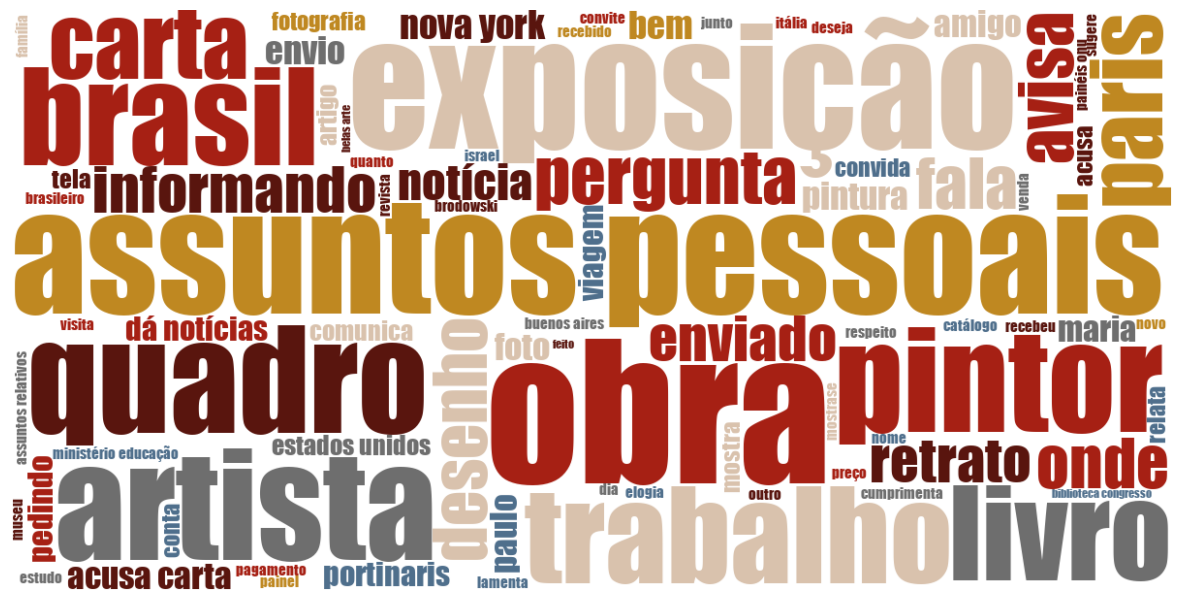

In [ ]:
cores_projeto = {
    'Azul': '#4F6F8C', 'Dourado': '#BF8821', 'Bege': '#D9C2AD',
    'Vermelho': '#A62014', 'Vinho': '#59150E', 'Cinza': '#6E6E6E'
}

def cor_customizada(word, font_size, position, orientation, random_state=None, **kwargs):
    return np.random.choice(list(cores_projeto.values()))

# limpeza de dados
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))
palavras_para_remover = [
    'informa', 'comenta', 'pede', 'agradece', 'trata', 'assunto', 
    'enviada', 'recebimento', 'comunicando', 'solicita', 'enviando', 'portinari',
    'acusando', 'diz', 'faz', 'sobre', 'ter', 'ainda', 'pode', 
    'null', 'ser', 'todos', 'parte', 'nesta', 'neste',
    'através', 'devido', 'forma', 'apresenta', 'envia', 'casa', 'rio', 'janeiro','fazer','fez','irá','envie','´dá'
]
stop_words.update(palavras_para_remover)

def limpar(texto):
    texto = re.sub(r'[^\w\s]', '', str(texto).lower())
    return " ".join([w for w in texto.split() if w not in stop_words])

# carregar
df = pd.read_csv('Data/dados_finais.csv')
texto_final = " ".join(df['memo_resumo'].apply(limpar))

caminho_fonte = "C:/Windows/Fonts/impact.ttf" 

# gerar nuvem
nuvem = WordCloud(
    width=1200, 
    height=600, 
    background_color='white',
    max_words=80, 
    font_path=caminho_fonte, 
    prefer_horizontal=0.7, 
    random_state=42
).generate(texto_final)

# exibir
plt.figure(figsize=(15, 10))
plt.imshow(nuvem.recolor(color_func=cor_customizada), interpolation='bilinear')
plt.axis('off')
plt.show()

## 5.6 Remetentes por período

#### Filtragem por período dos anos e resposta imediata da quantidade.

In [ ]:
def limpar_data(x):
    if pd.isna(x): return None
    x = str(x).strip()
    if len(x) == 4 and x.isdigit(): return f"01/01/{x}"
    if x.startswith('/'): return '01' + x
    if x.startswith('//'): return '01/01' + x[2:]
    return x

df['data_clean'] = df['data'].apply(limpar_data)
df['data_final'] = pd.to_datetime(df['data_clean'], format='%d/%m/%Y', errors='coerce')
df['ano'] = df['data_final'].dt.year

# agora vamos focar apenas nas mensagens onde o destinatário é "Candido Portinari" para analisar os remetentes e a linha do tempo dessas correspondências
df['destinatario_norm'] = df['destinatario'].astype(str).str.strip()
df_analise = df[df['destinatario_norm'] == 'Candido Portinari'].copy()

# remover mensagens onde o remetente também é "Candido Portinari" para focar nos interlocutores
df_clean = df_analise.dropna(subset=['ano', 'remetente']).copy()
df_clean['ano'] = df_clean['ano'].astype(int)

# construção da visualização

# seletor de intervalo (brush) para filtrar os gráficos dinamicamente por ano
brush = alt.selection_interval(encodings=['x'])

# top remetentes (quem mais escreveu para Portinari) considerando o filtro de tempo do brush
top_remetentes = alt.Chart(df_clean).mark_bar(color=cores['Vinho']).transform_filter(
    brush # primeiro aplica o filtro de data selecionado
).transform_aggregate(
    count='count()',
    groupby=['remetente'] # conta quantas cartas cada um mandou NESSE período
).transform_window(
    rank='rank(count)',
    sort=[alt.SortField('count', order='descending')] # cria um ranking do maior para o menor
).transform_filter(
    alt.datum.rank <= 15 # mantém apenas os 15 primeiros
).encode(
    x=alt.X('count:Q', title='Quantidade de Cartas'),
    y=alt.Y('remetente:N', title='Remetente', sort='-x'), # ordena a barra visualmente
    tooltip=['remetente', 'count:Q']
).properties(
    width=1000,
    height=400, # aumentei a altura para caber os nomes confortavelmente
    title="Top 15 Remetentes de Portinari no Período Selecionado"
)

# linha do tempo de correspondências recebidas por ano, com filtro interativo
timeline = alt.Chart(df_clean).mark_area(
    color=cores['Azul'],
    opacity=0.6,
    line=True
).encode(
    x=alt.X('ano:O', title='Selecione um intervalo de anos', axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('count():Q', title='Volume Recebido')
).add_params( 
    brush
).properties(
    width=1000,
    height=300
)

# final
dashboard = alt.vconcat(
    top_remetentes,
    timeline
).configure_view(
    strokeWidth=0
).configure_title(
    font = fonte_padrao,
    fontSize= 25,
    anchor='middle'
).configure_axis(
    titleFont = fonte_padrao,
    labelFont = fonte_padrao
)

# salvar
dashboard.save('Views/dashboard_remetentes_portinari.html')
dashboard.show()

alt.VConcatChart(...)

## 5.7 Explorador de correspondências

#### O Explorador de Correspondências possui uma timeline interativa com múltiplos filtros, permitindo buscas textuais nos resumos, segmentação por remetente, destinatário ou tipo de documento e uma análise clara da cronologia das comunicações.

In [22]:
# tratamento de datas para a visualização temporal
def limpar_data(x):
    if pd.isna(x): return None
    x = str(x).strip()
    # Se tiver apenas ano (ex: 1930), assume 01/01/1930
    if len(x) == 4 and x.isdigit(): return f"01/01/{x}"
    # Se for parcial como /07/1930, assume dia 01
    if x.startswith('/'): return '01' + x
    if x.startswith('//'): return '01/01' + x[2:]
    return x

df['data_clean'] = df['data'].apply(limpar_data)
df['data_final'] = pd.to_datetime(df['data_clean'], format='%d/%m/%Y', errors='coerce')

# remover quem ficou sem data válida para a visualização temporal
df_vis = df.dropna(subset=['data_final']).copy()
df_vis['Ano'] = df_vis['data_final'].dt.year

# mapeamos as categorias mais comuns para as cores de destaque
domain_tipos = df_vis['tipo_doc'].unique().tolist()
range_cores = [cores['Azul'], cores['Vermelho'], cores['Dourado'], cores['Vinho'], cores['Bege'], cores['Cinza']]

# se o tipo tiver mais categorias do que cores, o Altair vai repetir as cores, mas isso é melhor do que deixar sem cor ou criar uma paleta gigante.
input_busca = alt.param(
    name='Busca',
    bind=alt.binding(input='search', placeholder='Digite termo do resumo...', name='Pesquisar no Resumo: '),
    value=''
)

# seletor de Dropdown para Remetente
top_remetentes = df_vis['remetente'].value_counts().head(50).index.tolist()
top_remetentes.sort() 
top_remetentes.insert(0, None)

# seletor de Dropdown para Destinatário
top_destinatarios = df_vis['destinatario'].value_counts().head(50).index.tolist()
top_destinatarios.sort() # ordena alfabeticamente
top_destinatarios.insert(0, None) 

input_remetente = alt.param(
    name='FiltroRemetente',
    bind=alt.binding_select(options=top_remetentes, name='Filtrar Remetente: '),
    value=None
)

input_destinatarios = alt.param(
    name='FiltroDestinatario',
    bind=alt.binding_select(options=top_destinatarios, name='Filtrar Destinatário: '),
    value=None
)

# seleção para clicar na legenda e filtrar os tipos de documento
selecao_legenda = alt.selection_point(fields=['tipo_doc'], bind='legend')

# construção do gráfico de dispersão temporal

base = alt.Chart(df_vis).mark_circle(size=80, opacity=0.8, stroke='white', strokeWidth=0.5).encode(

    x=alt.X('data_final:T', title='Ano', axis=alt.Axis(format='%Y', grid=False)),
    
    # usamos o tipo de documento no eixo Y para criar faixas horizontais, mas sem um significado numérico, apenas para organizar visualmente
    y=alt.Y('tipo_doc:N', title='Tipo de Documento'),

    color=alt.Color(
        'tipo_doc:N', 
        scale=alt.Scale(domain=domain_tipos, range=range_cores),
        title='Tipo de Documento'
    ),
   
    tooltip=[
        alt.Tooltip('id_doc', title='ID'),
        alt.Tooltip('data_final', title='Data', format='%d/%m/%Y'),
        alt.Tooltip('remetente', title='Remetente'),
        alt.Tooltip('destinatario', title='Destinatário'),
        alt.Tooltip('memo_resumo', title='Resumo')
    ]
).add_params(
    # adicionando os interativos
    selecao_legenda,
    input_busca,
    input_remetente,
    input_destinatarios
).transform_filter(
    # lógica de Filtragem
    selecao_legenda 
).transform_filter(
    # filtro de remetente: se o usuário não escolher nada (None), mostra tudo, caso contrário, filtra pelo remetente selecionado
    f"FiltroRemetente == null || datum.remetente == FiltroRemetente"
).transform_filter(
    f"FiltroDestinatario == null || datum.destinatario == FiltroDestinatario"
).transform_filter(
    # filtro de busca no resumo: se o campo de busca estiver vazio, mostra tudo, caso contrário, filtra usando regex para encontrar o termo no memo_resumo (case-insensitive)
    f"test(regexp(Busca, 'i'), datum.memo_resumo)"
).properties(
    title='Explorador de Correspondências',
    width=1000,
    height=700,
    background=cores['Branco'] 
).configure_title(
    fontSize=30,
    offset=30,
    font=fonte_padrao,
    color=cores['Preto'],
    anchor='middle'
).configure_axis(
    labelFont=fonte_padrao,
    titleFont=fonte_padrao,
    grid=True,
    gridColor=cores['Bege'], 
    gridOpacity=0.5
).configure_legend(
    titleFont=fonte_padrao,
    labelFont= fonte_padrao,
    titleFontSize=12,
    labelFontSize=11,
    strokeColor='gray',
    fillColor=cores['Branco'],
    padding=10,
    cornerRadius=5
).interactive() 

# salvar
base.save('Views/Portinari_Text_Explorer.html')
base

alt.Chart(...)

## 5.8 Visualização em Grafo (Necessita das Bibliotecas Pyvis e Networkx)

#### O Grafo de Rede Social mapeia as conexões de Portinari por meio de uma visualização interativa com grafo, permitindo identificar interlocutores centrais e explorar toda a rede de comunicação entre remetentes e destinatários.  
Obs.: O link desta visualização se encontra após o código abaixo.

In [34]:
import networkx as nx
from pyvis.network import Network

# limpeza
df['remetente'] = df['remetente'].astype(str).str.strip()
df['destinatario'] = df['destinatario'].astype(str).str.strip()

# remove nulos e inválidos
df_rede = df[
    (df['remetente'].notna()) & (df['remetente'] != 'nan') &
    (df['destinatario'].notna()) & (df['destinatario'] != 'nan')
].copy()

# conta frequência (peso das conexões)
edges_df = df_rede.groupby(['remetente', 'destinatario']).size().reset_index(name='weight')

# Filtro de densidade (Mínimo de interações)
MINIMO_CORRESPONDENCIAS = 2
edges_filtered = edges_df[edges_df['weight'] >= MINIMO_CORRESPONDENCIAS].copy()

# --- remover nós isolados (que não têm conexões suficientes)
G_temp = nx.Graph()
G_temp.add_edges_from(zip(edges_filtered['remetente'], edges_filtered['destinatario']))

if len(G_temp) > 0:
    maior_componente = max(nx.connected_components(G_temp), key=len)
    edges_filtered = edges_filtered[
        edges_filtered['remetente'].isin(maior_componente) & 
        edges_filtered['destinatario'].isin(maior_componente)
    ].copy()
    print(f"Nós isolados removidos. Mantidos {len(maior_componente)} nós no grupo principal.")

# recalcula a lista de pessoas
todos_envolvidos = list(set(edges_filtered['remetente'].unique().tolist() + edges_filtered['destinatario'].unique().tolist()))

# calcula o tamanho dos nós 
total_msgs = {}
for pessoa in todos_envolvidos:
    enviadas = edges_filtered[edges_filtered['remetente'] == pessoa]['weight'].sum()
    recebidas = edges_filtered[edges_filtered['destinatario'] == pessoa]['weight'].sum()
    total_msgs[pessoa] = enviadas + recebidas

# --- construção do grafo

# paleta
cores2 = {
    'Azul': '#778A8C', 'Musgo': '#97A6A4', 'Vermelho': '#8C2020', 'Bege': '#D9D4D2',
    'Vinho': '#73413D', 'Branco': "#FFFFFF", 'FundoEscuro': '#222222'
}

# inicializa a rede
net = Network(height="750px", width="100%", bgcolor=cores2['FundoEscuro'], font_color=cores2['Branco'], notebook=True, cdn_resources='in_line')

for i, pessoa in enumerate(todos_envolvidos):
    tamanho = np.log(total_msgs[pessoa] + 1) * 10
    
    cor_node = [cores2['Azul'], cores2['Bege'], cores2['Vermelho'], cores2['Vinho']][i % 4]
    
    # configurações especiais para o hub central
    if pessoa == "Candido Portinari":
        e_hub = True
        x_pos = 0
        y_pos = 0
        physics_status = False 
        cor_node = cores2['Musgo']
        tamanho = tamanho * 3
    else:
        e_hub = False
        x_pos = None
        y_pos = None
        physics_status = True

    if pessoa == "Maria Portinari":
        cor_node = "#FF33AD"
        tamanho = tamanho * 2 
    
    # destaque especial para João Candido Portinari
    if pessoa == "João Candido Portinari":
        cor_node = "#2DEAFF"
        tamanho = tamanho * 1.8 

    net.add_node(
        pessoa,
        label=pessoa,
        title=f"{pessoa}\nTotal de Trocas na Rede: {total_msgs[pessoa]}",
        color=cor_node,
        size=tamanho,
        x=x_pos, 
        y=y_pos,
        physics=physics_status, 
        fixed=e_hub 
    )

# nova estrutura para armazenar as arestas mescladas
merged_edges = {}

# processa as arestas para agrupar conversas de ida e volta
for _, row in edges_filtered.iterrows():
    rem = row['remetente']
    dest = row['destinatario']
    w = row['weight']

    # criar um par ordenado para garantir que (A, B) e (B, A) sejam tratados como o mesmo par
    par = tuple(sorted([rem, dest]))

    if par not in merged_edges:
        merged_edges[par] = {
            'no_origem': rem,
            'no_destino': dest,
            'peso_ida': w,
            'peso_volta': 0,
            'total': w
        }
    else:
        # se o par já existe, significa que achamos a mensagem de volta
        if merged_edges[par]['no_origem'] == dest:
            merged_edges[par]['peso_volta'] = w
        else:
            merged_edges[par]['peso_ida'] += w 
        
        merged_edges[par]['total'] += w

# definir as arestas com base na nova estrutura mesclada
for par, dados in merged_edges.items():
    n1 = dados['no_origem']
    n2 = dados['no_destino']
    w_ida = dados['peso_ida']
    w_volta = dados['peso_volta']
    
    espessura = np.log(dados['total'] + 1)
    
    # definir direção e tooltip
    linhas_tooltip = []
    
    if w_ida > 0 and w_volta > 0:
        direcao = 'to, from' # Seta dupla!
        linhas_tooltip.append(f"➔ {n1} enviou {w_ida} documento(s) para {n2}")
        linhas_tooltip.append(f"➔ {n2} enviou {w_volta} documento(s) para {n1}")
    elif w_ida > 0:
        direcao = 'to' # Seta simples
        linhas_tooltip.append(f"➔ {n1} enviou {w_ida} documento(s) para {n2}")
    else:
        direcao = 'from' # Seta invertida
        linhas_tooltip.append(f"➔ {n2} enviou {w_volta} documento(s) para {n1}")

    tooltip_final = f"Total da Conversa: {dados['total']}\n-------------------\n" + "\n".join(linhas_tooltip)

    net.add_edge(
        n1,
        n2,
        value=espessura,
        title=tooltip_final,
        arrows=direcao
    )

# finalizações visuais
options = """
var options = {
  "nodes": {
    "font": { "size": 16, "face": "Helvetica", "color": "#ffffff" },
    "borderWidth": 2,
    "shadow": true
  },
  "edges": {
    "color": { 
      "color": "rgba(0,0,0,0)", 
      "highlight": "#FFFFFF",   
      "hover": "#FFFFFF",       
      "inherit": false 
    },
    "smooth": { "type": "continuous" }
  },
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -150000,
      "centralGravity": 0.005,
      "springLength": 800,
      "springConstant": 0.01,
      "damping": 0.09,
      "avoidOverlap": 1
    },
    "stabilization": {
      "enabled": true,
      "iterations": 3000
    },
    "minVelocity": 0.75
  },
  "interaction": {
    "hover": true,
    "tooltipDelay": 200,
    "hideEdgesOnDrag": true,
    "zoomView": true,
    "hoverConnectedEdges": true,
    "selectConnectedEdges": true
  }
}
"""
net.set_options(options)

# salvar
nome_arquivo = "Views/grafo_correspondencias.html"
net.show(nome_arquivo)

# Modificação do HTML para incluir um painel de informações personalizado

# 1. Lê o arquivo HTML recém-gerado pelo Pyvis
with open(nome_arquivo, "r", encoding="utf-8") as f:
    html_content = f.read()

# 2. Define o painel informativo com HTML e CSS (usando as cores da sua paleta)
painel_informacoes = """
<div style="position: absolute; top: 120px; left: 20px; z-index: 9999; 
            background-color: rgba(34, 34, 34, 0.85); color: #FFFFFF; 
            padding: 15px 20px; border-radius: 8px; 
            font-family: Helvetica, Arial, sans-serif; 
            border: 1px solid #D9C2AD; box-shadow: 2px 2px 10px rgba(0,0,0,0.5);
            max-width: 300px;">
    
    <p style="font-size: 14px; line-height: 1.4;">
        Análise das interações documentais. Nós representam pessoas, e as conexões indicam a quantidade de correspondências trocadas. Clique nos nós para detalhes e explore as conexões para entender a dinâmica das relações.
    </p>
    <hr style="border-color: #4F6F8C;">
    
    <h3 style="font-size: 16px; margin-bottom: 10px;">Legenda:</h3>
    <ul style="list-style-type: none; padding-left: 0; font-size: 14px; line-height: 1.8;">
        <li><span style="color: #97A6A4; font-size: 18px;">■</span> Candido Portinari</li>
        <li><span style="color: #2DEAFF; font-size: 18px;">■</span> João Candido Portinari</li>
        <li><span style="color: #FF33AD; font-size: 18px;">■</span> Maria Portinari</li>
        <li><span style="color: #FFFFFF; font-size: 18px;">━</span> Conexão (Enviadas/Recebidas)</li>
    </ul>
</div>
"""

#2.1 Título e descrição do painel
titulo_painel = """<h2 style="margin-top: 0; font-size: 30px; color: #BF8821; text-align: center;">Rede de Correspondências</h2>
<p style="text-align: center; font-size: 16px; color: #D9C2AD; margin-bottom: 20px; text-align: center"> Dê zoom e clique para explorar</p>
"""


# 3. Injeta o painel logo após a abertura da tag <body>
html_modificado = html_content.replace('<body>', f'<body>\n{titulo_painel}\n{painel_informacoes}')

# 4. Sobrescreve o arquivo HTML com a nova versão
with open(nome_arquivo, "w", encoding="utf-8") as f:
    f.write(html_modificado)

Nós isolados removidos. Mantidos 427 nós no grupo principal.
Views/grafo_correspondencias.html


#### Algumas das visualizações, como a que está acima, só estão disponíveis no link do Github pages: [Visualizações interativas](https://vrsmic.github.io/portinari-metadata/)

# 6. Conclusão e referências

Realizar este projeto como conclusão do curso de introdução à ciência de dados foi extremamente enriquecedor, pois conseguimos explorar a base de dados de um grande artista brasileiro e sobretudo entender como é o trabalho de analisar e visualizar tantos e tão importantes dados. Foi uma tarefa extensa, mas que trouxe resultados e uma exploração incrível. Sentimos que agora conhecemos e pretendemos ainda conhecer um pouquinho mais de Cândido Portinari.  
Um agradecimento à professora Asla, por ministrar o curso e propor este projeto!

Referências:  

ALHARBI, Mohammad; LARAMEE, Robert S. SoS TextVis: A Survey of
Surveys on Text Visualization. In: TAM, G.; VIDAL, F. (Eds.). EG UK Computer
Graphics & Visual Computing. Swansea, UK: The Eurographics Association, 2018.
p. 1-10.  

JÄNICKE, S. et al. Visual text analysis in digital humanities. Computer Graphics
Forum, v. 36, n. 6, p. 226-250, 2017.  

PORTINARI, João Candido. Projeto Portinari: O resgate de uma obra e de uma
época. Estudos Avançados, v. 13, n. 35, p. 141-158, 1999.  

PROJETO PORTINARI. Portal de Documentos e Correspondências
(DocReader). Disponível em: https://www.docvirt.com/DocReader.net/coportinari.  

SILICON VALLEY DATA SCIENCE. The History of Rock and Roll in 100 Riffs. 2016. Disponível em: https://svds.com/rockandroll/#therollingstones. 